In [44]:
from torchvision.models import resnet50, ResNet50_Weights, VGG16_Weights, vgg16
%matplotlib inline

from PIL import Image,ImageChops
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

from torchvision import datapoints
from torchvision.io import read_image
import torch
import numpy as np

from typing import Callable, Optional
import torch

from imagenet_labels import labels
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
net = resnet50(weights=ResNet50_Weights.DEFAULT)

## 1.1: Download code for class activation mapping (CAM and/or grad-CAM)

In [3]:
# Imagenet mean/std
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [4]:
model = net
# model = models.resnet50(pretrained=True)
#model.cuda()
model.eval()
print()

In [5]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

final_layer = model._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

In [6]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

#weight_softmax_params

def imageWithCam(imgPath, requires_grad=True, nofPred=1,
                 ax = None, overlay_map = True):
    """
    Plots the image with cam
    """
    if ax is None:
        fig, ax = plt.subplots(dpi=300)
    
    if isinstance(imgPath, str):
        image = Image.open(imgPath)
    else:
        image = imgPath
        
    if np.array(image).shape[2]==4:
        image = image.convert('RGB')
   
    # Reinstantiate the model 
    model = net
    model.eval()
    final_layer = model._modules.get('layer4')
    activated_features = SaveFeatures(final_layer)

    tensor = preprocess(image)

    prediction_var = Variable((tensor.unsqueeze(0)), requires_grad)
    prediction = model(prediction_var)
    pred_probabilities = F.softmax(prediction).data.squeeze()
    activated_features.remove()
    #print(topk(pred_probabilities,nofPred))
    class_idx = topk(pred_probabilities,nofPred)[1].int()
    #print(class_idx)
    overlay = getCAM(activated_features.features, weight_softmax, class_idx[nofPred-1])
    # Print the predicted label
    #print(f"Predicted label: {labels[class_idx]}")

    #print(class_idx[nofPred-1])
    
        
    ax.imshow(display_transform(image))
    if overlay_map:
        #print('hej')
        ax.imshow(overlay[0], alpha=0.5, cmap='jet')
        ax.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet')
    
    ax.set_title(f"Predicted label: {labels[class_idx]}", size=9)

    return ax
  #return fig

## 1.2. Get 3 images from the internet and see how the attention maps for the prediction of the network change

In [87]:
# Set base path for imgs
base_path = "cam_imgs"

imgs = {
    "zebra":f"{base_path}/zebra.jpg",
    "organ":f"{base_path}/pipe_organ.jpg",
    "piggy bank":f"{base_path}/piggy_bank.jpg",
    #"group_1": f"{base_path}/group_photo_1.png",
    #"group_2": f"{base_path}/group_photo_2.png"
}


### 1.2.1: Affine Image transformations, i.e., rotation, flipping, shift etc.

In [8]:
torch.manual_seed(123)
transform1 = transforms.Compose(
    [
        transforms.RandomRotation(180),
    ]
)

### 1.2.2: Additive noise, i.e., salt and pepper noise, gaussian filtering, median blur, unsharp filter

In [9]:
import torch
def add_gaussian_noise(y, mean=0, std=150/255):

    noise = torch.randn(y.shape) * std + mean
    return (y + noise).clamp(0, 1) # * 255

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_gaussian_noise(x, mean=0, std=150/255)),
    transforms.ToPILImage()
])



### 1.2.3: Intensity transformation, i.e, flipping the RGB channels, histogram equalization 

In [10]:
def flipRGB(image):

    image_new  = image[[2,1,0],...]
    return image_new

transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: flipRGB(x)),
    transforms.ToPILImage(),
])


# Example usage
def affine_img(ori_image,transform=transform1):
    image = ori_image
    image = read_image(str(image))
    image = np.transpose(image.numpy(), (1, 2, 0))
    image = Image.fromarray(image)
    image1_new1 = transform(image)

    return image1_new1

In [ ]:
fig, axs = plt.subplots(ncols=len(imgs), nrows=4, dpi =300, figsize=(10, 15))
for i, (trans_type, transformation) in enumerate(zip(["No transformation", "Rotation", "Salt and pepper", "RGB swap"], 
                                                   [None, transform1, transform2, transform3])):
    
    for j, (name, img) in enumerate(imgs.items()):
       # print(name)
    

        if transformation is not None:
            img = affine_img(imgs[name], transformation)
        #print(type(img))
        imageWithCam(img, requires_grad=True, nofPred=1, ax = axs[i][j], overlay_map=False)
    
        if j == 0:
            axs[i][j].set_ylabel(trans_type)
            
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        #else:
        #    axs[i][j].axis("off")

fig.tight_layout()
plt.savefig("figs/transformed_grid.pdf")

In [ ]:
fig, axs = plt.subplots(ncols=len(imgs), nrows=4, dpi =300, figsize=(10, 15))
for i, (trans_type, transformation) in enumerate(zip(["No transformation", "Rotation", "Salt and pepper", "RGB swap"], 
                                                     [None, transform1, transform2, transform3])):
    
    for j, (name, img) in enumerate(imgs.items()):
       # print(name)
    

        if transformation is not None:
            img = affine_img(imgs[name], transformation)
        #print(type(img))
        imageWithCam(img, requires_grad=True, nofPred=1, ax = axs[i][j], overlay_map=True)
        if j == 0:
            axs[i][j].set_ylabel(trans_type)
            
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
       

fig.tight_layout()
plt.savefig("figs/transformed_overlay_grid.pdf")

## 1.3: Repeat the above task for Layer-wise relevance propagation LRP (see links below). Comment on the usefulness of the different techniques.

In [52]:
from captum.attr import LayerLRP
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [67]:
# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
net = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

In [68]:
#net.features[0]

In [69]:
# Read and preprocess img
zebra = Image.open(imgs["zebra"])
transformed_img = preprocess(zebra)

In [70]:
# Calculate layer attribution w.r.t. frst conv layer
layer_lrp = LayerLRP(net, net.features[0])
attributions_ig = layer_lrp.attribute(transformed_img[None, :, :, :],
                                      target=labels.index("zebra"),
                                      attribute_to_layer_input=True).squeeze().permute(1, 2, 0).detach().numpy()

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [71]:
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

**Note!:** Change /lib/python3.10/site-packages/captum/attr/_utils/visualization.py  line 250 from
```python
 plt_axis.grid(b=False)
```
to
```python
  plt_axis.grid(visible=False)
```

In [102]:
def plot_lrp(imgs, model:str="vgg"):
    
    default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)
    
    for name, img_path in imgs.items():
        
        if model == "vgg":
            net = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
            layer_lrp = LayerLRP(net, net.features[0])
        elif model == "resnet":
            net = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
            layer_lrp = LayerLRP(net, net.conv1)
        else:
            raise Exception("Incorrect model")
        
        img = Image.open(img_path)
        transformed_img = preprocess(img)
        attributions_ig = layer_lrp.attribute(transformed_img[None, :, :, :],
                                              target=labels.index(name),
                                              attribute_to_layer_input=True).squeeze().permute(1, 2, 0).detach().numpy()
        
        
        ax = viz.visualize_image_attr_multiple(attributions_ig,
                             transformed_img.permute(1, 2, 0).cpu().detach().numpy(),
                             #np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                            ["original_image", "heat_map"],
                              ["all", "absolute_value"],
                              cmap=default_cmap,
                              show_colorbar=True)
        
    

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


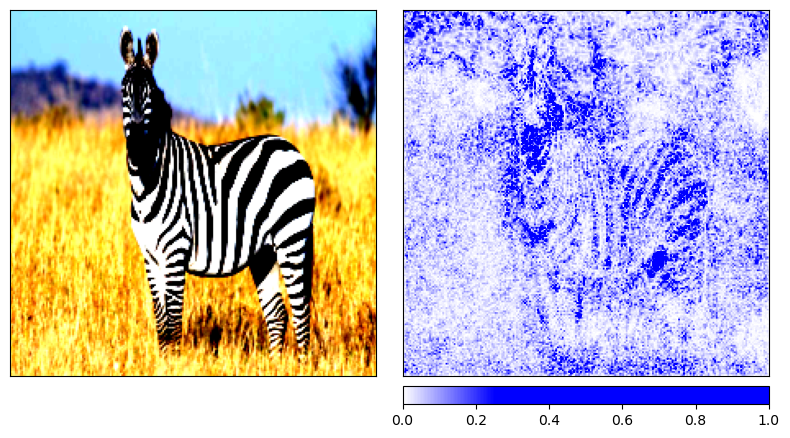

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


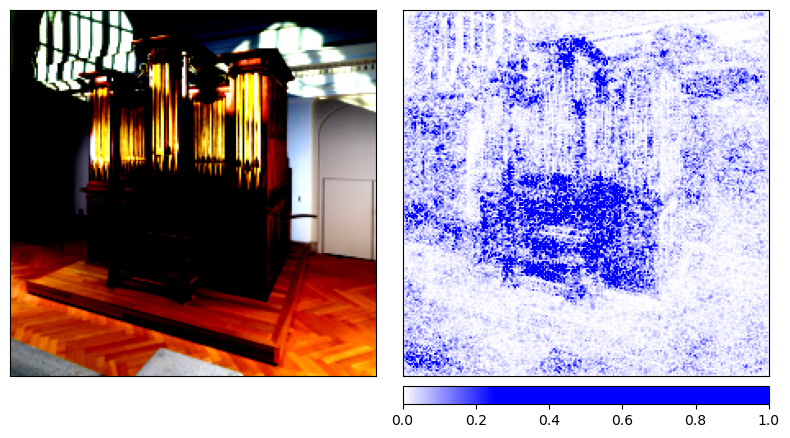

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


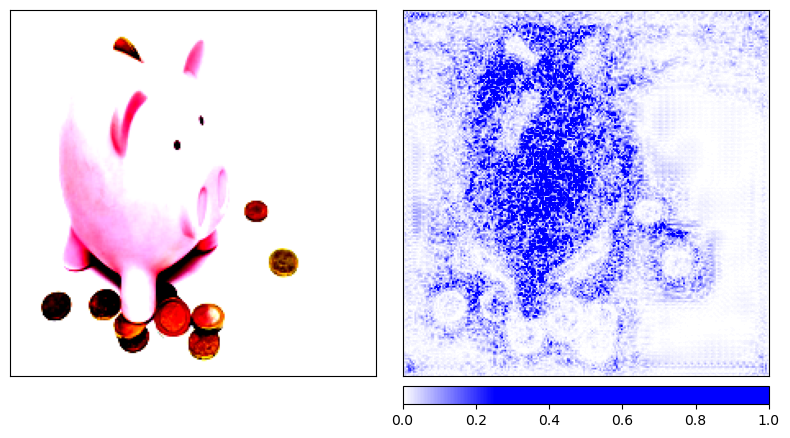

In [103]:
plot_lrp(imgs, model="vgg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


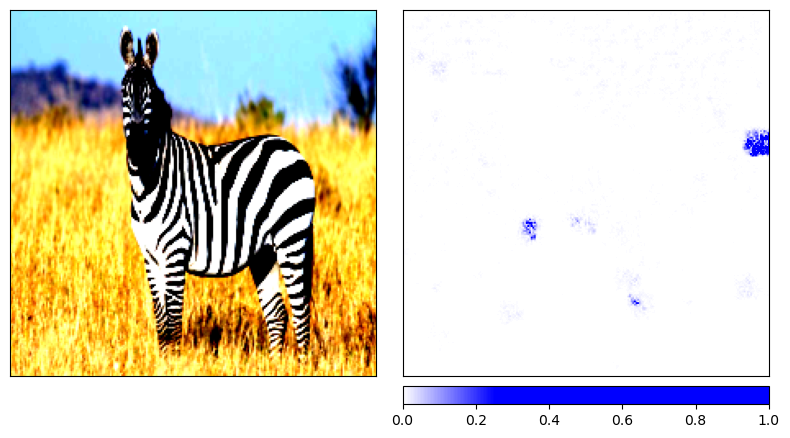

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


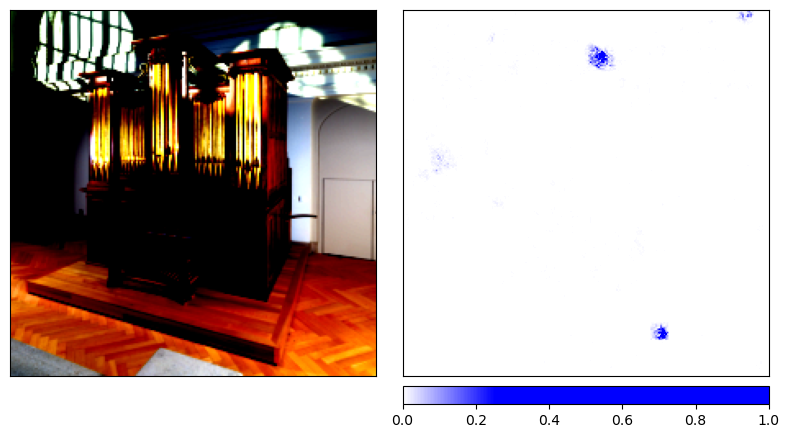

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


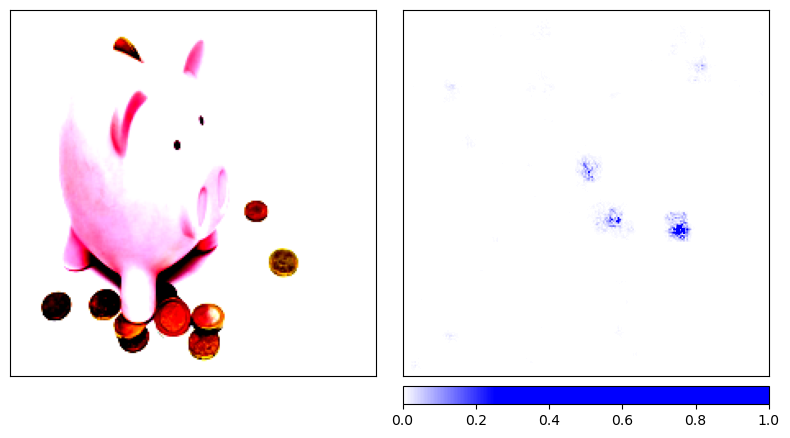

In [104]:
plot_lrp(imgs, model="resnet")

## 1.4: On a team photo, who gets most attention?